# Creating Loneliness Index from Prescription Data for Scotland

In [56]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

# Read drug data

In [57]:
# Path to zip files
path = "data-raw/Scotland/"

In [58]:
# Get drug data (NB some drugs duplicated for illnesses)
drug_data = pd.read_csv("drug_list.csv")

# Process Prescribing Data

This code iterates over the monthly prescribing data, ultimately producing an aggregate table.

**Filename format:** pitc[year][month].csv (e.g. pitc201801.csv)

**Columns:** HBT, GPPractice, BNFItemCode, BNFItemDescription, ClassOfPreparationCode, NumberOfPaidItems, PaidQuantity, GrossIngredientCost, PaidDateMonth

These files are the "Prescriptions in the Community" .csv files that come from: https://www.opendata.nhs.scot/dataset/prescriptions-in-the-community

In [59]:
# column names
col_bnfname = "BNFItemDescription"
col_items = "NumberOfPaidItems"

In [60]:
# Function to find loneliness related prescribing
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).fillna(False).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
    # Add loneliness related disease binary - avoids double counting some drugs.
    out['loneliness'] = x[col_bnfname].str.contains("|".join(drug_data['medication'].unique()),
                                                  case = False, 
                                                  regex = True).fillna(False).astype('int16')
    # Return dataframe multiplied by counts of items.
    return out.multiply(x[col_items], axis=0)

In [61]:
# Make dictionary for aggregation
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols[col_items] = 'sum'
agg_cols['loneliness'] = 'sum'
for key in ['Date', 'HBT']:
    agg_cols[key] = 'first'

In [62]:
monthly_data = []

for file in os.listdir(path + "Prescriptions"):
    # Open prescribing files in pandas.
    prescribe = pd.read_csv(path + "Prescriptions\\" + file)
    prescribe.columns = prescribe.columns.str.strip()
    # Rename 'PaidDateMonth' column to 'date'
    prescribe.rename(columns = {'PaidDateMonth': 'Date'}, inplace = True) 
    # Get counts of prescribing dataframe for loneliness related diseases
    loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
    # merge dataframes
    prescribe = prescribe.merge(loneliness_prescribing, left_index=True, right_index=True)
    del loneliness_prescribing

    # merge in address information
    #prescribe = prescribe.merge(addr, left_on = 'PracticeID', right_on = 'PracticeId')
    #del addr

    # Create uniform postcode field
    #prescribe['pcstrip'] = prescribe['Postcode'].str.replace("\s","")

    # get a summary - grouping by GPPractice
    summary = prescribe.groupby('GPPractice', as_index=False).agg(agg_cols)
    del prescribe

    monthly_data.append(summary)
    print(file)


pitc202201.csv
pitc202202.csv
pitc202203.csv
pitc202204.csv
pitc202205.csv
pitc202206.csv
pitc202207.csv
pitc202208.csv
pitc202209.csv
pitc202210.csv
pitc202211.csv
pitc202212.csv


In [66]:
# concatenate all the monthly data together.
data = pd.concat(monthly_data, ignore_index = True)

In [67]:
data[data["loneliness"] > 0].head()

,GPPractice,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,Date,HBT
0,10002,594,20,700,704,107,485,41,0,3,9510,1951,202201,S08000030
1,10017,550,35,658,664,89,420,56,0,5,8734,1814,202201,S08000030
2,10036,376,11,579,582,62,344,59,0,6,6136,1434,202201,S08000030
3,10106,513,34,719,724,106,505,39,1,2,8541,1922,202201,S08000030
4,10125,425,15,453,454,91,367,44,0,4,6673,1396,202201,S08000030


In [68]:
# Save aggregated data
data.to_csv(path + "processed_data.csv")

# Import GP Practices

## Use only General Practice surgeries

Use the 'GP Practice Contact Details and List Sizes' data from: https://www.opendata.nhs.scot/dataset/gp-practice-contact-details-and-list-sizes to get GP surgery codes and number of registered patients.

Note that Scotland only publishes these data four times a year (in Jan, Apr, Jul and Oct) - so we'll just use the previous quarter's numbers until the next quarter (e.g. use Jan 18 data for Jan/Feb/Mar)

**Filename format:** gppractices[year][month][day].csv (e.g. gppractices20180101.csv)

**Columns:** PracticeCode, PracticeName, PracticeListSize, AddressLine1, AddressLine2, AddressLine3, AddressLine4, Postcode, TelephoneNumber, PracticeType, Dispensing, HB2014 [Health Board], HB1995 [Health Board], HSCP2016 [Health and Social Care Partnership], CA2011 [Council Area], DZ2011 [Data Zone], DZ2001 [Data Zone]

In [69]:
data = pd.read_csv(path + "processed_data.csv", index_col = 0)

In [70]:
# Get GP files
gp_path = path + "GP data/"

In [74]:
gp_combine = []

for file in os.listdir(gp_path):
    
    # Deal with different file structures
    gp_data = pd.read_csv(gp_path + file)
    #gp_data.columns = gp_data.columns.str.upper().str.replace(" ","_")
    gp_data = gp_data.rename(columns = {'PracticeCode': 'GPPractice'})
    gp_combine.append(gp_data[['GPPractice','Postcode']])
    print(file)

gppractices20220101.csv
gppractices20220701.csv
gppractices20221001.csv


In [75]:
# concatenate all the gp data together.
gp_data = pd.concat(gp_combine, ignore_index = True)

In [76]:
gp_data.head(3)

,GPPractice,Postcode
0,10002,DD2 5NH
1,10017,PH7 3SA
2,10036,PH15 2BL


In [77]:
len(gp_data)

2747

In [78]:
# Get the unique codes for GP surgeries and subset the prescribing data according to these codes.
gp_ids = gp_data['GPPractice'].unique()
data = data[data['GPPractice'].isin(gp_ids)].copy()
data.shape

(11121, 14)

In [79]:
# Merge on the basis GPPractice code
data = data.merge(gp_data, how = 'left', on = ['GPPractice'])

In [80]:
data.head(2)

,GPPractice,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,Date,HBT,Postcode
0,10002,594,20,700,704,107,485,41,0,3,9510,1951,202201,S08000030,DD2 5NH
1,10002,594,20,700,704,107,485,41,0,3,9510,1951,202201,S08000030,DD2 5NH


In [81]:
# Create uniform postcode field
data['pcstrip'] = data['Postcode'].str.replace("\s","")

In [82]:
# Check for 1 postcode per Practice Code
pc_prac_counts = data.groupby('GPPractice')['pcstrip'].unique().map(len)
# 28 practices have more than 1 postcode associated with it.
pc_prac_counts[pc_prac_counts > 1].count()

12

In [86]:
pc_prac_counts[pc_prac_counts > 1]

GPPractice
16066    2
21505    2
40046    2
40224    2
40262    2
40582    2
40691    2
40703    2
62986    2
70470    2
71171    2
71379    2
Name: pcstrip, dtype: int64

In [87]:
# Save aggregated data
data.to_csv(path + "processed_data_with_postcode.csv")

# Generate Statistics from Prescribing Counts

## Percentages At Postcode Level

Aggregate observations to postcodes and compute percentages for 'depression', 'alzheimers', 'blood pressure', 'hypertension', 'diabetes', 'cardiovascular disease', 'insomnia', 'addiction', 'social anxiety', and 'loneliness'.

## Outlier Removal

Should we remove some GPs on the basis that they have very low/high values which might indicate they are not accessible to the general population, and instead represent specialist services?

Currently, we won't do this, but it's an advanced task to look into.

## Standardise Percentages

Should we standardise within time points, or across them? Or standardise with GP practices or across them?

Can't standardize within GPs, as can't then compare between GPs.

Can't standardise across GPs within years, as can't then compare between years.

Can't standardise across GPs across years, as can't then disambiguate changes to rank order over time.

<u> First Step </u>

Take the average percentage of disease groups within postcodes annually - this is then an annual summary measure of prescribing by postcode. Aggregation entire depends on desired time frame for analysis.

NB, this is a mean of percentages - could also calculate an overall percentage by summing monthly counts by year and dividing through by monthly sum of items.

<u> Second Step </u>

z-score standardise for earliest year observed across GPs. Store mean and standard deviation.

z-score standardise subsequent years wrt baseline mean and standard deviation.

OR

Use min-max normalisation by year (decile normalisation?). This standardises the different percentages to the same range - although in theory they're comparable anyway...

## Aggregation and Percentages

In [88]:
data = pd.read_csv(path + "processed_data_with_postcode.csv", index_col=0)

In [89]:
data.dtypes

GPPractice                 int64
depression                 int64
alzheimers                 int64
blood pressure             int64
hypertension               int64
diabeties                  int64
cardiovascular disease     int64
insomnia                   int64
addiction                  int64
social anxiety             int64
NumberOfPaidItems          int64
loneliness                 int64
Date                       int64
HBT                       object
Postcode                  object
pcstrip                   object
dtype: object

In [90]:
# Make dictionary for aggregation
# counts to sum
agg_cols = {col : 'sum' for col in drug_data['illness'].unique()}
agg_cols[col_items] = 'sum'
agg_cols['loneliness'] = 'sum'

# Other data to preserve
for key in ['HBT', 'Postcode', 'Date']:
    agg_cols[key] = 'first'

In [91]:
agg_cols

{'depression': 'sum',
 'alzheimers': 'sum',
 'blood pressure': 'sum',
 'hypertension': 'sum',
 'diabeties': 'sum',
 'cardiovascular disease': 'sum',
 'insomnia': 'sum',
 'addiction': 'sum',
 'social anxiety': 'sum',
 'NumberOfPaidItems': 'sum',
 'loneliness': 'sum',
 'HBT': 'first',
 'Postcode': 'first',
 'Date': 'first'}

In [92]:
# Do aggregation and produce counts by postcode by date.
data = data.groupby(['pcstrip', 'Date'], as_index=False).agg(agg_cols)

In [93]:
data

,pcstrip,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,NumberOfPaidItems,loneliness,HBT,Postcode,Date
0,AB10 1NW,2136,63,1818,1854,291,1149,189,24,33,29379,5706,S08000020,AB10 1NW,202201
1,AB10 1NW,2070,48,1764,1788,255,1125,180,21,33,27033,5487,S08000020,AB10 1NW,202202
2,AB10 1NW,2361,54,2025,2073,327,1293,183,24,54,32073,6315,S08000020,AB10 1NW,202203
3,AB10 1NW,2286,48,2007,2043,285,1197,159,21,48,29625,6039,S08000020,AB10 1NW,202204
4,AB10 1NW,2403,81,1971,1998,339,1293,204,21,42,32514,6339,S08000020,AB10 1NW,202205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8847,ZE2 9RW,402,6,693,696,114,426,0,0,0,7092,1644,S08000026,ZE2 9RW,202208
8848,ZE2 9RW,351,12,528,531,117,330,3,0,0,5601,1344,S08000026,ZE2 9RW,202209
8849,ZE2 9RW,393,9,627,627,126,378,0,0,0,6138,1533,S08000026,ZE2 9RW,202210
8850,ZE2 9RW,366,0,528,528,123,342,0,0,0,5817,1359,S08000026,ZE2 9RW,202211


In [94]:
# Generate percentages
perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

# Percentages for discrete illness groups out of total drugs prescribed
data[target_cols] = data[perc_cols].divide(data[col_items], axis=0) * 100

# Overall percentage for loneliness realted disease prescribing out of total drugs prescribed
data['loneliness_perc'] = data['loneliness'].divide(data[col_items], axis=0) * 100

In [95]:
data.head(3)

,pcstrip,depression,alzheimers,blood pressure,hypertension,diabeties,cardiovascular disease,insomnia,addiction,social anxiety,...,depression_perc,alzheimers_perc,blood pressure_perc,hypertension_perc,diabeties_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc,loneliness_perc
0,AB10 1NW,2136,63,1818,1854,291,1149,189,24,33,...,7.270499,0.214439,6.188094,6.310630,0.990503,3.910957,0.643317,0.081691,0.112325,19.422036
1,AB10 1NW,2070,48,1764,1788,255,1125,180,21,33,...,7.657308,0.177561,6.525358,6.614138,0.943292,4.161580,0.665853,0.077683,0.122073,20.297414
2,AB10 1NW,2361,54,2025,2073,327,1293,183,24,54,...,7.361332,0.168366,6.313722,6.463380,1.019549,4.031428,0.570573,0.074829,0.168366,19.689458


## Standardisation (z-scores)

In [96]:
# Calculate the z scores per illness

# Make new column names.
per_cols = ['depression_perc', 'alzheimers_perc', 'blood pressure_perc', 'hypertension_perc', 
            'diabeties_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc']

# Calculate Z-scores for each column
for i, col in enumerate(per_cols):
    col_zscore = col[:-5] + 'zscore'  # New column name for Z-scores
    data[col_zscore] = stats.zscore(data[col])


In [97]:
data['loneliness_zscore'] = data[[ 'depressionzscore', 'alzheimerszscore',
       'blood pressurezscore', 'hypertensionzscore', 'diabetieszscore',
       'cardiovascular diseasezscore', 'insomniazscore', 'addictionzscore',
       'social anxietyzscore']].sum(axis=1)

<Axes: >

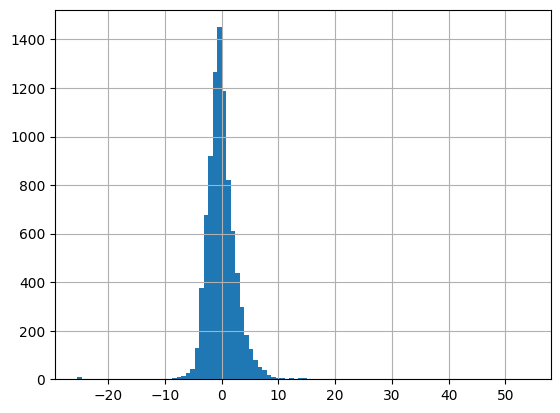

In [98]:
data.loneliness_zscore.hist(bins=100)

array([[<Axes: title={'center': '0'}>]], dtype=object)

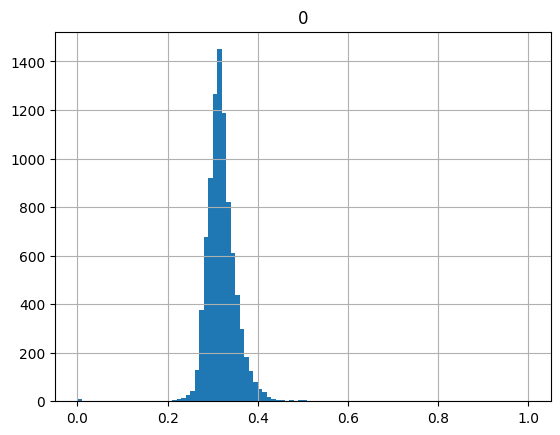

In [99]:
scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(data[['loneliness_zscore']])).hist(bins=100)